# Test formation of quasicrystal by projection of high-dimentional unit cells

In [1]:
%matplotlib inline
from neurotools.nlab import *
from edges_and_triangles import *

import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

Loading nlab namespace
Could not locate the spectrum module, please install it
Multitaper methods will not work
Could not locate the spectrum module, please install it
Multitaper methods will not work


In [2]:
# Generate a collection of paths in M dimensions
# Use the unit vector projection to identify the point location
# TODO: we need a better datastructure for detecting identical points
# I don't know how to do this theoretically unless they occupy
# The same location in the higher-dimensional lattice?

# Hypothesis: two projections are identical if and only if their unit vectors agree? 
# This may speed things up?

# Still not fast enough. Let's grow the graph from a seed
# Using the high-dimensional representation
# Iteratively, but only adding points that are close to the plane?
# This *may* involve computing distance to a hyperplane. Yuck.
# Hmm.

# What if we test points by projecting into 2D and out again and seeing whether this operation is a fixed point?
# This didn't work as I hoped. 

# Lets try to write a routine to expand the tiling based on unit vector representation

In [3]:
# Dimensionality of crystal
M = 4
# Scale 
K = 10
# Maximum radius of pattern
R = 3
# Number of nearest-neighbor edge hops to compute when defining the lattice tiling
I = 10
# number of hops to expand the graph before culling back to 2d
H = 3

# Define 2D projection unit vectors
phases  = arange(M)*pi/M
units2d = np.float32([cos(phases),sin(phases)])

# Define the M-D basis unit vectors (orhtonormal)
basis = np.int8(np.eye(M))

# Define units step vectors in all M dimensions
steps = np.concatenate([basis,-basis])

In [4]:
# To check whether a point is on the hyperplane, project from M -> 2 -> M?
# This is linear, combine
project2d = units2d.T.dot(units2d)
project2d.shape

# Construct an approximation of the M-D basis using the 2D unit vectors
basis2d = project2d.dot(basis)

# I think this is the orthogonal complement?
complement = basis - basis2d
ocomp = scipy.linalg.orth(complement)

# Check ocomp is full rank
print(det(ocomp))

# Check ocomp is unitary
print(ocomp.T.dot(ocomp))

# Check that ocomp and units2D are orthogonal This should be zero
print(units2d.dot(ocomp))

ocomp.shape

1.0
[[  1.00000000e+00   5.19804999e-08   3.79984222e-09   6.51258325e-10]
 [  5.19804999e-08   1.00000012e+00  -4.75602739e-08  -2.40307307e-09]
 [  3.79984222e-09  -4.75602739e-08   9.99999940e-01  -4.21468478e-08]
 [  6.51258325e-10  -2.40307307e-09  -4.21468478e-08   1.00000000e+00]]
[[  4.85033240e-08   1.20443708e-08   9.99999940e-01  -1.00000000e+00]
 [ -6.78598344e-01  -1.24076772e+00  -1.26880515e-08  -1.01751496e-07]]


(4, 4)

# Construct tiling in unit representation? 

Retain explicit notion of a tile as a pair of M-D integer points separated by two different unit hops? This representation is ambiguous as (0,2) and (-1,+1) are both valid representations. Maybe by convention use the minimum, maximum?

In [5]:
center = np.zeros(M,np.int8)
seedtiles = [(center,center + steps[i-1] + steps[i]) for i in range(len(steps))]

In [6]:
def pointNeighborhood(p):
    '''
    p : MD point
    '''
    return p + steps

print(pointNeighborhood(center))

[[ 1  0  0  0]
 [ 0  1  0  0]
 [ 0  0  1  0]
 [ 0  0  0  1]
 [-1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0 -1]]


In [7]:
def canonicalTile(tile):
    '''
    Ensure tile is in canonical format
    '''
    a,b = tile
    delta = b-a
    if not np.all(abs(delta)<=1):
        raise ValueError('Tiles are separated by more than one 2d facet: %s, %s'%tile)
    if not np.sum(abs(delta))==2:
        raise ValueError('Tiles are separated by more than one 2d facet: %s, %s'%tile)
    a,b = np.array(np.minimum(a,b),dtype=a.dtype), np.array(np.maximum(a,b),dtype=b.dtype)
    assert sum(b-a)==2
    return a,b

print(canonicalTile(seedtiles[0]))

(array([ 0,  0,  0, -1], dtype=int8), array([1, 0, 0, 0], dtype=int8))


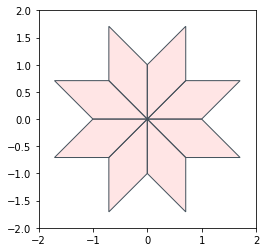

In [8]:
def tilePointsMD(tile):
    a,b = canonicalTile(tile)
    delta = np.where(b-a==1)[0]
    p1 = a
    p2 = np.int8(a) + basis[delta[0]]
    p3 = b
    p4 = np.int8(a) + basis[delta[1]]
    points = np.array([p1, p2, p3, p4])
    return points
    

def drawTile(tile):
    '''
    Tile should be passed as tuple of integer offsets into M-D space
    These should be separated by two hops in the M-D crystal lattice
    Hmm maybe another format might be easier to store?
    '''
    points = tilePointsMD(tile).dot(units2d.T)
    p = Polygon(points, True, edgecolor=BLACK, facecolor=(1,0,0,.1))
    gca().add_patch(p)

#drawTile(seedtiles[0])
[drawTile(s) for s in seedtiles]
xlim(-2,2)
ylim(-2,2)
force_aspect()

## Somehow expand tile set?

Only a subset of adjacent tiles are valid; how to understand? Try to find point with minimum norm? An adjacent tile shares an edge. Which means it shares one point and one delta. The tile can be completed by choosing the other delta. Tiles should not intersect. We can compute tile by adding one unit vector. Only allow new unit vectors in directions of increasing norm. 

Given a tile (a,b), adjacent tiles are ones that share an edge. 

In [9]:
def norm(v):
    return np.sqrt(np.sum(v**2))

def normsq(v):
    return np.sum(v**2)

In [10]:
def pointset(p):
    return set(list(map(tuple,np.int8(p))))

In [11]:
# To check whether a point is on the hyperplane, project from M -> 2 -> M?
# This is linear, combine
project2d = units2d.T.dot(units2d)
project2d.shape
# Define the M-D basis
basis = np.int32(np.eye(M))

(28, 4) (28,)
[[ 0  0  0 -1]
 [ 1  0  0 -1]
 [ 1  0  0  0]
 [ 0  0  0  0]] [1 2 1 0]


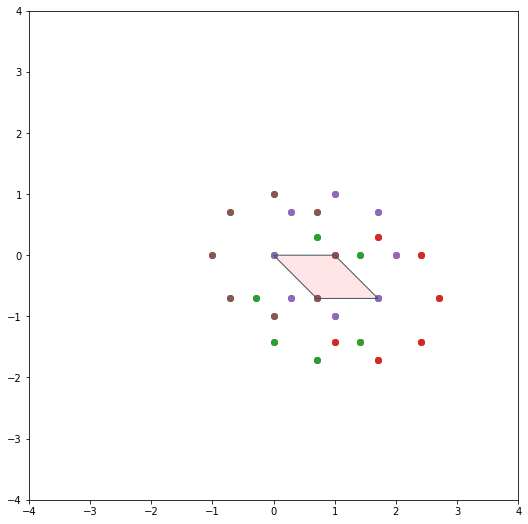

In [12]:
def adjacentTilePoints(tile):
    a,b = canonicalTile(tile)
    pp  = set()
    for p in tilePointsMD(tile):
        pp |= pointset(pointNeighborhood(p))
    return np.int8(list(pp))

figure(figsize=(9,9))
t = seedtiles[0]
p = adjacentTilePoints(t)

n = np.sum(p*p,axis=1)
print(p.shape,n.shape)

drawTile(t)
scatter(*units2d.dot(p.T))
scatter(*units2d.dot(p[n>sqrt(8)].T))

pp = tilePointsMD(t)
nn = np.sum(pp*pp,axis=1)
print(pp,nn)
for i in range(4):
    scatter(*units2d.dot(pointNeighborhood(pp[i]).T))

xlim(-4,4)
ylim(-4,4)
force_aspect()

In [13]:
def trio2Tile(p1,p2,p3):
    pp = np.int8([p1,p2,p3])
    distances = np.sum(np.abs(pp[:,None,:]-pp[None,:,:]),axis=2)
    if not np.sum(distances==2)==2:
        raise ValueError("Expected points to encode face")
    if not np.sum(distances==1)==4:
        raise ValueError("Expected points to encode face")
    return canonicalTile(pp[np.where(distances==2)[0]])

trio2Tile(steps[0],center,steps[1])

(array([0, 0, 0, 0], dtype=int8), array([1, 1, 0, 0], dtype=int8))

In [14]:
def adjacentTiles(tile):
    a,b = canonicalTile(tile)
    # new tiles found by locating points adjacent to a,b but with more extreme norm
    for p in tilePointsMD(tile):
        pp = pointNeighborhood(p)
        np = pp[ pp.dot(pp.T) > p.dot(p) ]
